## Classical 2D Ising Model w/ Monte Carlo sampling

Weight do not need to be 1 for Hopfield model, just the same constant and no self-interactions. Scale with 1/N^2

If your going to sum over all states anyway, you can calculate the mean value for each state right then.

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

In [2]:
# WEIGHT FUNCTIONS
#-----------------------------------------------------------------------------------------------------------

def get_weights_hopfield(w_self,w_other, N):
    ''' 
    Generates weights array for a fully connected system, with distinction between self and other interactions
    '''
    Wij = (w_other/(N**4-N**2)) * np.ones((N,N,N,N))
    np.fill_diagonal(Wij.reshape(N**2, N**2), w_self / N**2)   #give different value to self-interactions
    return Wij

def get_weights_nearest_neighbours(w_self,w_other):
    ''' 
    Generates weights array with only nearest neighbour interactions
    '''           
    Wij = np.zeros((N,N,N,N))                             #all weights are stored in this array

    np.fill_diagonal(Wij.reshape(N**2, N**2), w_self)
    
    I, J = np.indices((N, N))
    Wij[I, J, (I + 1) % N, J] = w_other
    Wij[I, J, (I - 1) % N, J] = w_other
    Wij[I, J, I, (J + 1) % N] = w_other
    Wij[I, J, I, (J - 1) % N] = w_other
    return Wij / N**2

def get_weights_nearest_neighbours(w_self,w_other, N):
    Wij = np.zeros((N,N,N,N))
    np.fill_diagonal(Wij.reshape(N**2, N**2), w_self)
    I, J = np.indices((N, N))
    Wij[I, J, (I + 1) % N, J] = w_other
    Wij[I, J, (I - 1) % N, J] = w_other
    Wij[I, J, I, (J + 1) % N] = w_other
    Wij[I, J, I, (J - 1) % N] = w_other
    return Wij / N**2

def get_weights_random():
    ''' 
    Generates random weights array
    '''
    Wij = np.random.rand(N,N,N,N) * w_other / N**2
    return Wij

In [32]:
##  SIMULATION FUNCTIONS
#----------------------------------------------------------------------

def initialstate(N):   
    ''' 
    Generates a random spin configuration for initial  condition
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state



def mcmove(config, Wij, beta):
    '''
    Monte Carlo move using Heat Bath algorithm and weighted interactions
    '''
    
    for i in range(N):                                   #Perform a sweep
        for j in range(N):
                energy = 0
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                
                energy = np.sum(Wij[a,b] * config) 
                if rand() < (1/(1+np.exp(2*s*energy*beta))): 
                    s *= -1
                    config[a, b] = s
    return config



def calcCorr(config): 
    '''
    Correlations of a given configuration
    '''
    SiSj = np.zeros((N,N,N,N))
    
    for i in range(len(config)):
        for j in range(len(config)):
            for a in range(len(config)):
                for b in range(len(config)):
                        if a == i and b == j:                      #This makes sure we get correct mean spins
                            SiSj[i][j][a][b] += config[i, j] 
                        else:
                            SiSj[i][j][a][b] += (config[i, j] * config[a % N, b % N])
                
    return SiSj


def calcEnergy(config, Wij):
    '''
    Energy of a given configuration
    '''
    energy = 0 
    
    for i in range(len(config)):
        for j in range(len(config)):
            s = config[i,j]
            energy += np.sum(-Wij[i][j] * config * s)
    return energy/2.  # to compensate for over-counting

def get_self_interactions(Wij):
    '''
    Simplifies the 4D weight tensor to a NxN matrix for the self-interactions only
    '''
    Wii = np.zeros((N,N))
    for i in range(N):
            for j in range(N):
                Wii[i][j] = Wij[i][j][i][j]
    return Wii
        

def calcMag(config, Wii):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(Wii*config)
    return mag

In [4]:
#  SOLVER FUNCTIONS
#-----------------------------------------------------------------------------------------------------------------

def ising_solve_exact(): 
    '''
    Sums over all possible configurations of the NxN lattice and calculates the intensive values.
    '''
    E,M,C,X,SiSj = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros((nt,N,N,N,N)) #store moments
    n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)  # divide by number of sample and system size to get intensive values

    for tt in range(nt):
        config = np.ones((N,N), dtype=int) #initialize the system
        E1 = M1 = E2 = M2 = 0
        SiSj_tot = np.zeros((N,N,N,N))
        
        iT=1.0/T[tt]; iT2=iT*iT;          # beta values

    
        for i in range(2**(N*N)):         #loop over all possible states
            config = np.array([[(i//(2**(n*N + m))) % 2 for m in range(N)] for n in range(N)], dtype=int)
            Ene = calcEnergy(config, Wij)      # calculate the energy
            Mag = calcMag(config, Wii)         # calculate the magnetisation
            SiSj_sweep = calcCorr(config) # calculate the correlations   


            E1 += Ene                     # add them to the total sum
            M1 += Mag
            M2 += Mag*Mag 
            E2 += Ene*Ene
            SiSj_tot += SiSj_sweep


        # divide by number of sites and iteractions to obtain intensive values
        E[tt] = n1*E1
        M[tt] = n1*M1
        C[tt] = (n1*E2 - n2*E1*E1)*iT2
        X[tt] = (n1*M2 - n2*M1*M1)*iT
        SiSj[tt] += SiSj_tot / mcSteps
    
    return E,M,C,X,SiSj 
    
    

def ising_solve_mc():     
    '''
    Calculate the intensive values using Monte Carlo Heat Bath sampling
    '''
    ##  initialize the system
    E,M,C,X,SiSj = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros((nt,N,N,N,N)) #store moments

    n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
    # divide by number of samples, and by system size to get intensive values

    for tt in range(nt):
        config = initialstate(N)         

        E1 = M1 = E2 = M2 = 0
        SiSj_tot = np.zeros((N,N,N,N))


        iT=1.0/T[tt]; iT2=iT*iT;          # beta values

        for i in range(eqSteps):          # equilibrate
            mcmove(config, Wij, iT)       # Monte Carlo moves

        for i in range(mcSteps):
            config = mcmove(config, Wij, iT)         
            Ene = calcEnergy(config, Wij)      # calculate the energy
            Mag = calcMag(config, Wii)         # calculate the magnetisation
            SiSj_sweep = calcCorr(config)      # calculate the correlations


            E1 += Ene
            M1 += Mag
            M2 += Mag*Mag 
            E2 += Ene*Ene
            SiSj_tot += SiSj_sweep


        # divide by number of sites and iteractions to obtain intensive values
        E[tt] = n1*E1
        M[tt] = n1*M1
        C[tt] = (n1*E2 - n2*E1*E1)*iT2
        X[tt] = (n1*M2 - n2*M1*M1)*iT
        SiSj[tt] += SiSj_tot / mcSteps
    
    return E,M,C,X,SiSj 

In [50]:
#  PARAMETERS
#--------------------------------------------------------------------

nt      = 18                 #  amount of steps in temperature
eqSteps = 2**8               #  number of MC sweeps for equilibration
mcSteps = 2**9               #  number of MC sweeps for calculation
N       = 8                  #  size of the lattice, N x N
w_other = 200                #  strength of interactions w/ lattice
w_self  = 5                  #  added strength of self-interactions compared to w_other

T   = np.linspace(1, 5, nt);  
Wij = get_weights_hopfield(w_self,w_other,N)  #choose between hopfield, nearest neighbour or random
Wii = get_self_interactions(Wij)

In [51]:
# run the simulations
#----------------------------------------------------------------------

#E_ex,M_ex,C_ex,X_ex,SiSj_ex = ising_solve_exact() 
E_mc,M_mc,C_mc,X_mc,SiSj_mc = ising_solve_mc() 

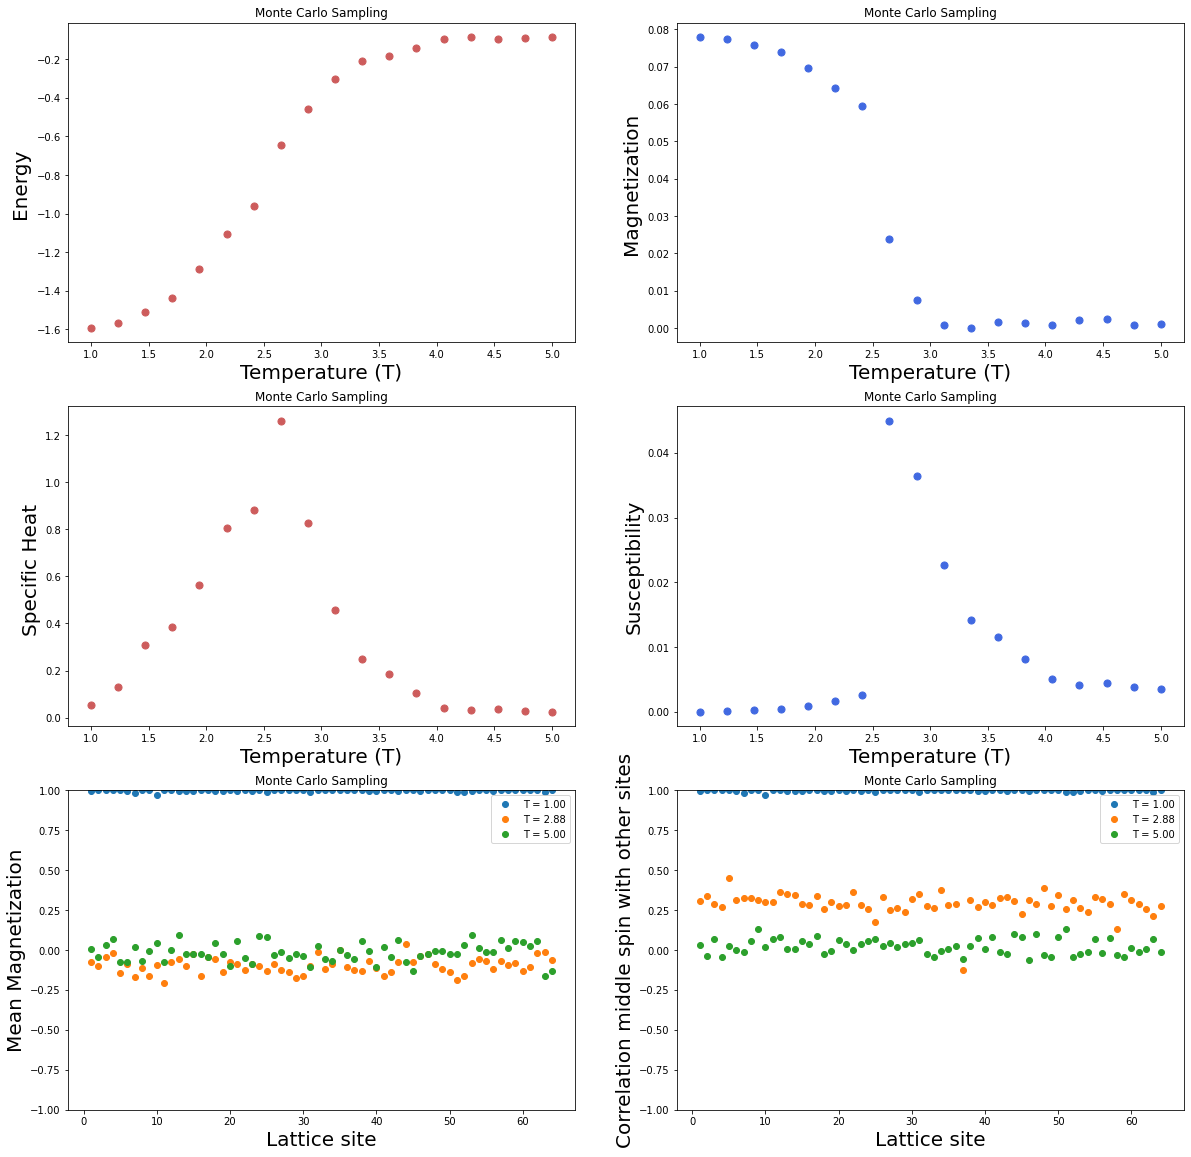

In [52]:
#  plot the calculated values for the MC Method
#----------------------------------------------------------------------

f = plt.figure(figsize=(20, 20)); #  
 

sp =  f.add_subplot(3, 2, 1 );
plt.title('Monte Carlo Sampling')
plt.scatter(T, E_mc, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(3, 2, 2 );
plt.title('Monte Carlo Sampling')
plt.scatter(T, abs(M_mc), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(3, 2, 3 );
plt.title('Monte Carlo Sampling')
plt.scatter(T, C_mc, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   


sp =  f.add_subplot(3, 2, 4 );
plt.title('Monte Carlo Sampling')
plt.scatter(T, X_mc, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(3, 2, 5 );
for i in range(len(SiSj_mc)):
    temp = T[i]
    sites = np.arange(1,N*N+1,1)
    Si = np.zeros((N,N))
    for a in range(N):
        for b in range(N):
            Si[a][b] = SiSj_mc[i][a][b][a][b]       
    Si = Si.reshape(N*N)
    
    if i == 0:       plt.plot(sites, Si, 'o', label='T = %.2f' % temp);
    if i == nt/4 - 1:    plt.plot(sites, Si, 'o', label='T = %.2f' % temp);
    if i == nt/2 - 1:  plt.plot(sites, Si, 'o', label='T = %.2f' % temp);
    if i == nt -1 :  plt.plot(sites, Si, 'o', label='T = %.2f' % temp); 

    plt.title('Monte Carlo Sampling')
    plt.xlabel('Lattice site', fontsize =20)
    plt.ylabel('Mean Magnetization', fontsize = 20);   plt.axis('tight')
    plt.legend()

sp.set_ylim([-1,1])


sp =  f.add_subplot(3, 2, 6 );
for i in range(len(SiSj_mc)):
    temp = T[i]
    
    if (N % 2) == 0:             #get middle spin lattice value
        m = int(N/2)
    else:
        m = int((N-1)/2)
    
    SiSj_mid = SiSj_mc[i][m][m].reshape(N**2)
    
    if i == 0:       plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp);
    if i == nt/4 - 1:    plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp);
    if i == nt/2 - 1:  plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp);
    if i == nt -1 :  plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp); 

    plt.title('Monte Carlo Sampling')
    plt.xlabel('Lattice site', fontsize =20)
    plt.ylabel('Correlation middle spin with other sites', fontsize = 20);   plt.axis('tight')
    plt.legend()

sp.set_ylim([-1,1])

plt.show()

In [ ]:
#  plot the calculated values for the exact summation
#----------------------------------------------------------------------

f = plt.figure(figsize=(20, 20)); #  
 

sp =  f.add_subplot(3, 2, 1 );
plt.title('Exact Calculation')
plt.scatter(T, E_ex, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(3, 2, 2 );
plt.title('Exact Calculation')
plt.scatter(T, abs(M_ex), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(3, 2, 3 );
plt.title('Exact Calculation')
plt.scatter(T, C_ex, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   


sp =  f.add_subplot(3, 2, 4 );
plt.title('Exact Calculation')
plt.scatter(T, X_ex, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(3, 2, 5 );
for i in range(len(SiSj_ex)):
    temp = T[i]
    sites = np.arange(1,N*N+1,1)
    Si = np.zeros((N,N))
    for a in range(N):
        for b in range(N):
            Si[a][b] = SiSj_ex[i][a][b][a][b]       
    Si = Si.reshape(N*N)
    
    if i == 0:       plt.plot(sites, Si, 'o', label='T = %.2f' % temp);
    if i == nt/4 - 1:    plt.plot(sites, Si, 'o', label='T = %.2f' % temp);
    if i == nt/2 - 1:  plt.plot(sites, Si, 'o', label='T = %.2f' % temp);
    if i == nt -1 :  plt.plot(sites, Si, 'o', label='T = %.2f' % temp); 

    plt.title('Exact Calculation')
    plt.xlabel('Lattice site', fontsize =20)
    plt.ylabel('Mean Magnetization', fontsize = 20);   plt.axis('tight')
    plt.legend()

sp.set_ylim([-1,1])


sp =  f.add_subplot(3, 2, 6 );
for i in range(len(SiSj_ex)):
    temp = T[i]
    
    if (N % 2) == 0:             #get middle spin lattice value
        m = int(N/2)
    else:
        m = int((N-1)/2)
    
    SiSj_mid = SiSj_ex[i][m][m].reshape(N**2)
    
    if i == 0:       plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp);
    if i == nt/4 - 1:    plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp);
    if i == nt/2 - 1:  plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp);
    if i == nt -1 :  plt.plot(sites, SiSj_mid, 'o', label='T = %.2f' % temp); 

    plt.title('Exact Calculation')
    plt.xlabel('Lattice site', fontsize =20)
    plt.ylabel('Correlation middle spin with other sites', fontsize = 20);   plt.axis('tight')
    plt.legend()

sp.set_ylim([-1,1])

plt.show()

## Compare to exact computation

Here 5x5 lattice was used. We used 10x10 so we have sharper peaks in the specific heat and magnetization, but besides that they look qualively the same

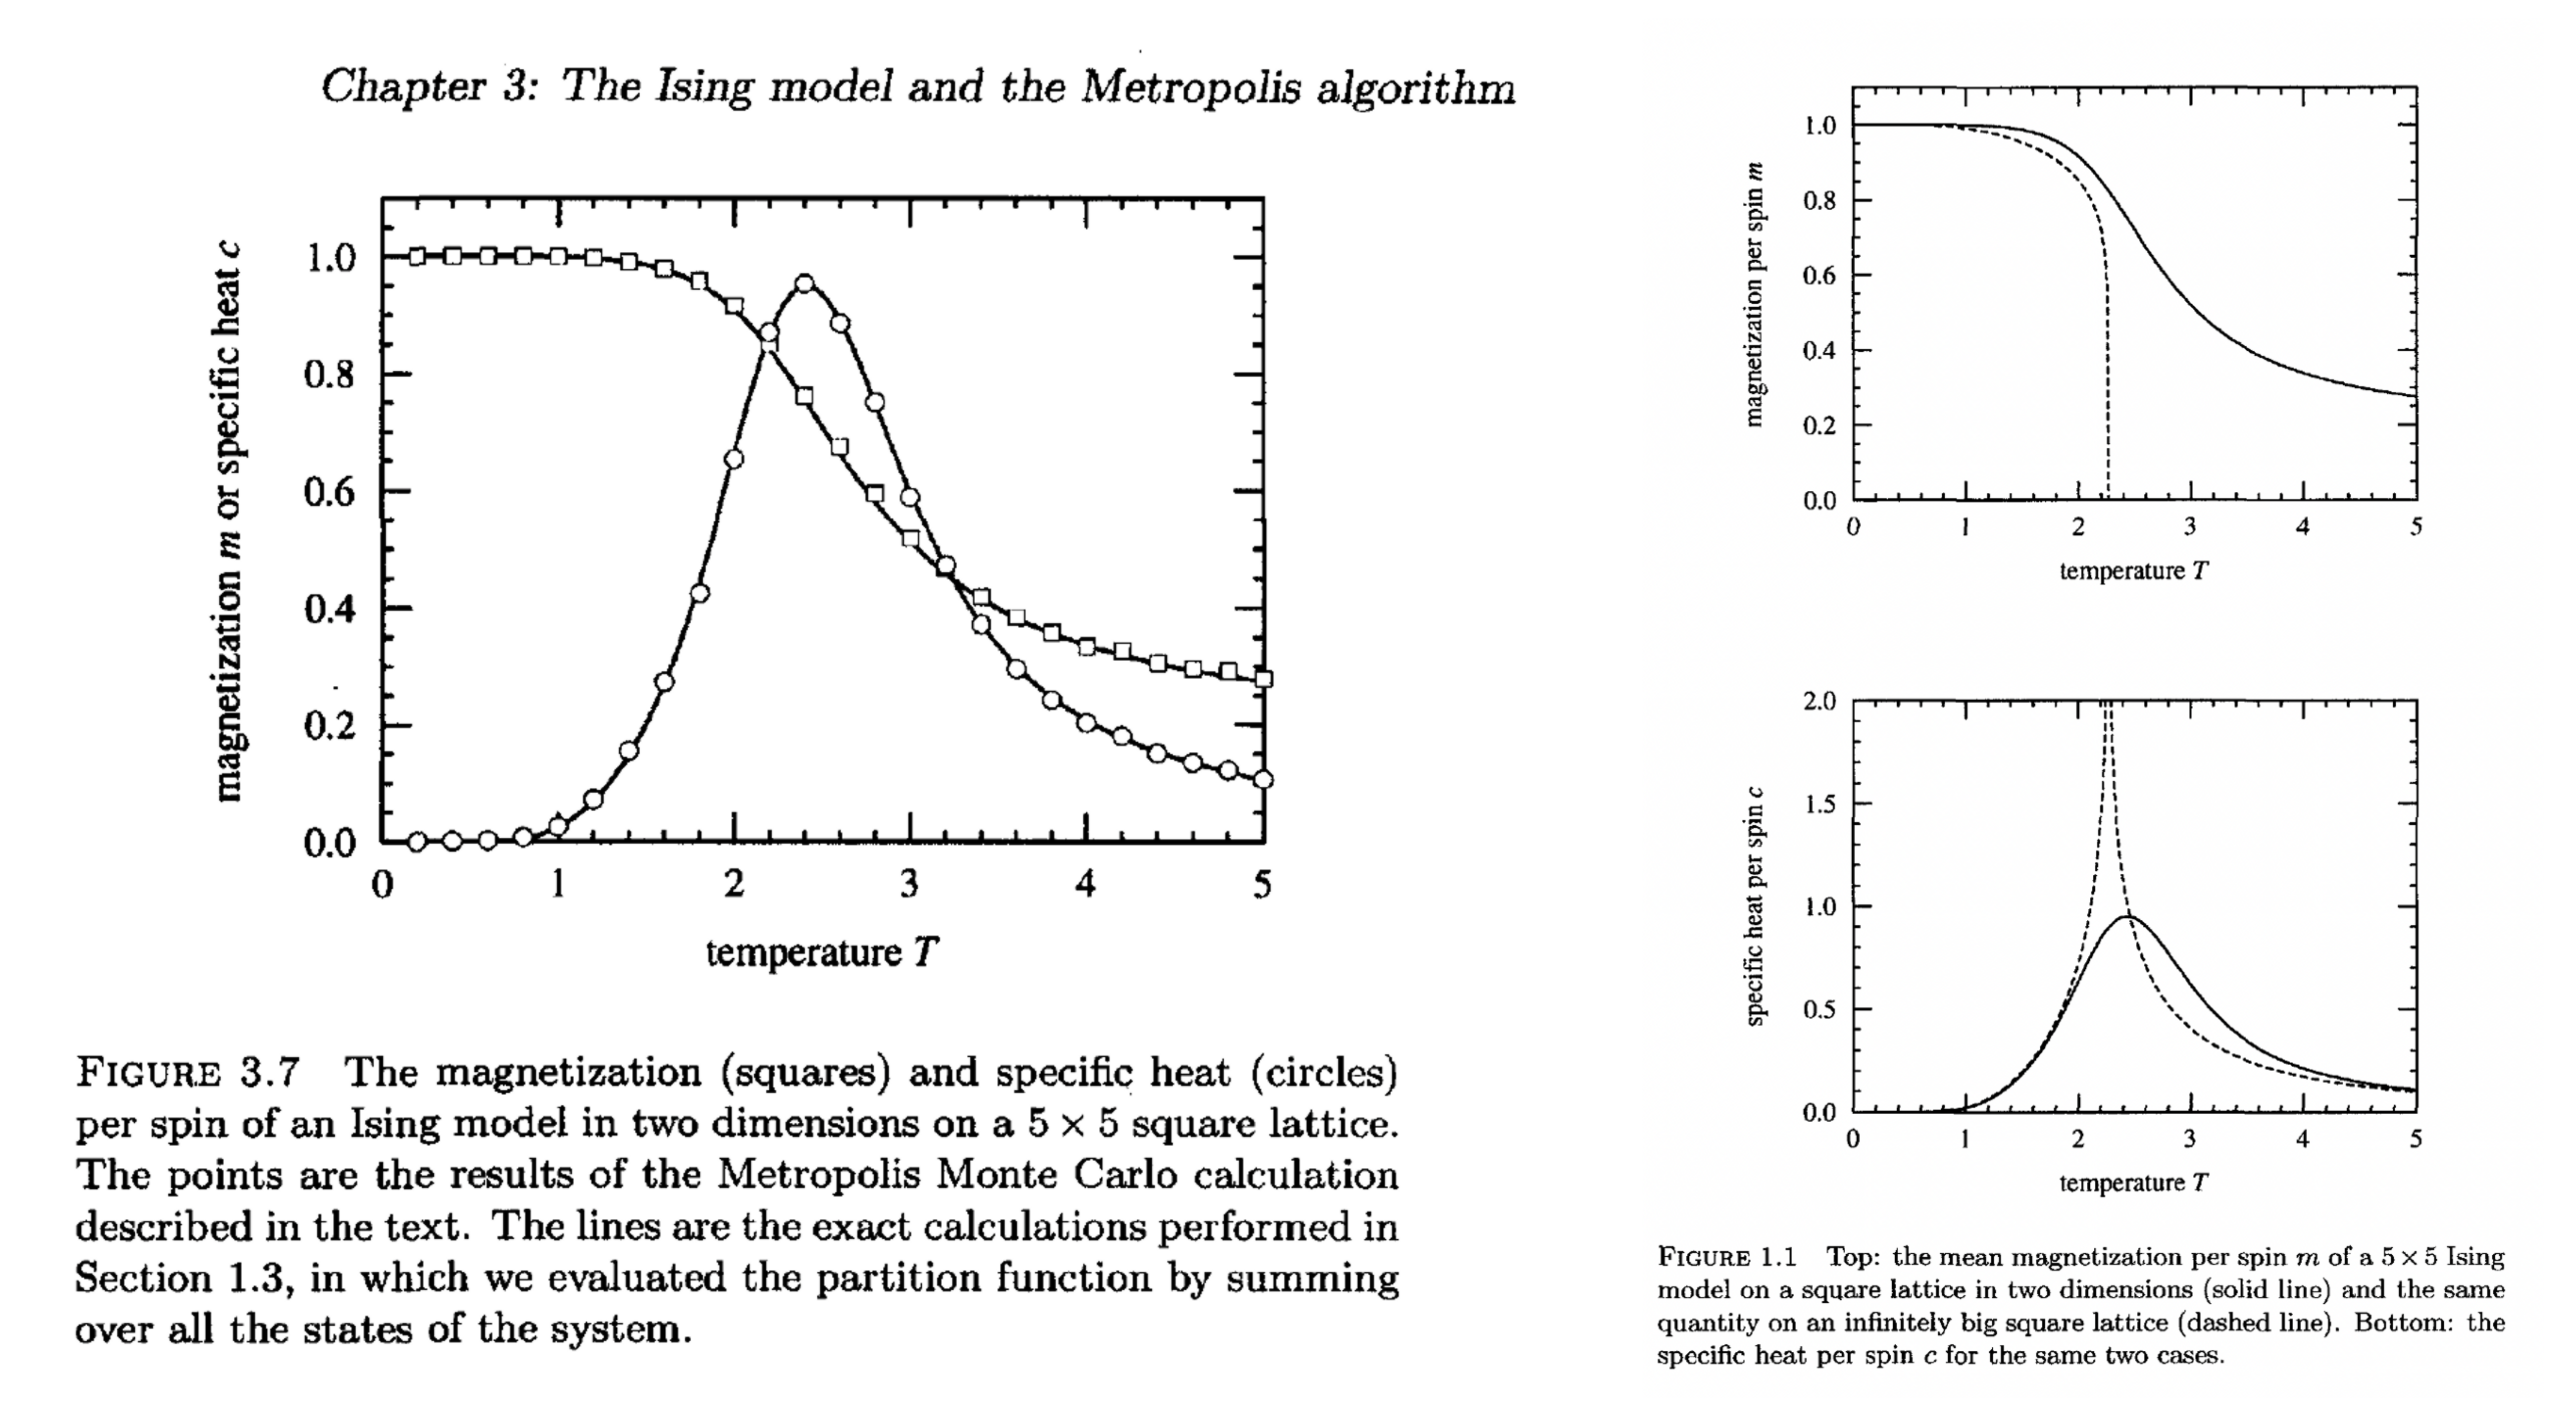

# Inverse Ising Problem
Starting from the sampled data, infer the interaction parameters of the classical hamiltonian by constructing a classical Boltzmann machine.

In [ ]:
##  PARAMETERS
#----------------------------------------------------------------------
# stop constants: 
threshold_Wi = 1e-6
threshold_Wij = 1e-2

eqSteps = 2**8  
maxiter = 2**11

# learning rate:
eta = 1/300

In [ ]:
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------

Si_temp = np.zeros(nt*N*N).reshape((nt,N*N))
SiSj_temp = np.zeros(nt*N**4).reshape((nt,N*N,N*N))
Wi_temp = np.zeros(nt*N*N).reshape((nt,N*N))
Wij_temp = np.zeros(nt*N**4).reshape((nt,N*N,N*N))

for tt in range(nt):
    
    temp = T[tt]
    iT=1.0 / T[tt]

    Si =  np.zeros(N*N)                                #initialise free statistics
    SiSj = np.zeros(N**4).reshape((N*N,N*N))

    Si_clamped = Si[tt]                              #initialise clamped statistics
    SiSj_clamped = SiSj[tt]

    Si_tot = np.zeros(N**2)          
    SiSj_tot = np.zeros(N**4).reshape((N*N,N*N)) 

    np.random.seed(777)                               #random initial weights
    Wi = np.random.rand(N*N)
    Wij = np.random.rand(N**4).reshape((N*N,N*N))      


    config = initialstate(N)                           #initialise the Boltzmann machine
    it = 0
    di = dij = 1                     
    it = 0

    for i in range(eqSteps):                           #equilibriate
        config = mcmove_weighted(config, Wi, Wij, iT)
        
    
    while di > threshold_Wi and it < maxiter:        #start gradient ascent loop
        it += 1
        config = mcmove_weighted(config, Wi, Wij, iT)                       #get MC values
        Sis, SiSjs = calcCorr_weighted(config, Wi, Wij)

        Si_tot += Sis                                                       #calculate free stats
        Si = Si_tot / it
        SiSj_tot += SiSjs
        SiSj = SiSj_tot / it

        Wi += eta * (Si_clamped - Si)                                       #update weights                  
        Wij += eta * (SiSj_clamped - SiSj)

        di = np.square(np.dot(Si - Si_clamped, Si - Si_clamped))
        dij = sum(sum(np.square(np.dot(SiSj - SiSj_clamped, SiSj - SiSj_clamped))))
    
    Si_temp[tt] += Si
    SiSj_temp[tt] += SiSj
    Wi_temp[tt] += Wi
    Wij_temp[tt] += Wij
    
    print("For temperature {}: \nAmount of iterations = {} \nSi distance from maximum = {} \nSiSj distance from maximum = {}".format(temp,it, di, dij))
    print("------------------------------\n")

In [ ]:
#  PRINT RESULTS & CHECK VALIDITY
#----------------------------------------------------------------------

temp = 28  #select temperature point you'd like to print results of

print('For temperature %.2f \n----------------------''\nSelf interactions Wi:' % T[temp])
print(Wi_temp[temp].reshape(10,10))
print('\n \n Interactions of the middle spin Wij:')
print(Wij_temp[temp][50].reshape(10,10))
print('\n \nCompare free and clamped statistics:\n')
print('Si')
print(Si_temp[temp].reshape(10,10))
print('\nSi_clamped')
print(C_Si[temp].reshape(10,10))
print('\nSiSj[50]')
print(SiSj_temp[temp][50].reshape(10,10))
print('\nSi_clamped[50]')
print(SiSj[temp][50].reshape(10,10))